In [ ]:
!pip install transformers
!pip install optuna
!pip install wandb
!pip install tqdm
!pip install pandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 8.1 MB/s 
     |████████████████████████████████| 6.6 MB 55.7 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 81.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 9.9 MB/s 
     |████████████████████████████████| 209 kB 85.3 MB/s 
     |████████████████████████████████| 81 kB 11.2 MB/s 
     |████████████████████████████████| 78 kB 8.9 MB/s 
     |████████████████████████████████| 112 kB 92.5 MB/s 
     |████████████████████████████████| 146 kB 92.9 MB/s 
     |████████████████████████████████| 49 kB 7.4 MB/s 
  Created wheel for pype

In [ ]:
import pandas as pd
import numpy as np
import string

import optuna
import torch.optim as optim
from tqdm.notebook import tqdm

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/datasets/fake reviews dataset.csv')
def punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
data['text']= data['text_'].apply(lambda x:punctuation(x))
data['text']= data['text'].apply(lambda x: x.lower())
data

,category,rating,label,text_,text
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",love this well made sturdy and very comfortab...
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",love it a great upgrade from the original ive...
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,this pillow saved my back i love the look and ...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",missing information on how to use it but it is...
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,very nice set good quality we have had the set...
...,...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...,i had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...,i wasnt sure exactly what it would be it is a ...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ...",you can wear the hood by itself wear it with t...
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...,i liked nothing about this dress the only reas...


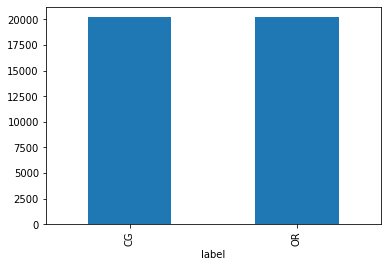

In [ ]:
data.groupby(['label']).size().plot.bar()

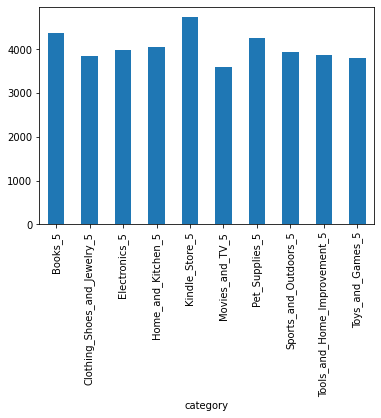

In [ ]:
data.groupby(['category']).size().plot.bar()

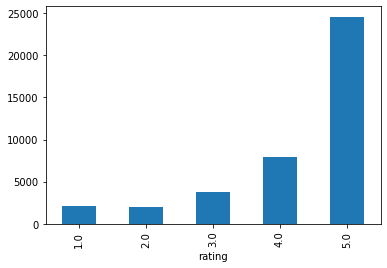

In [ ]:
data.groupby(['rating']).size().plot.bar()

In [ ]:
from transformers import BertTokenizer
len(data['text'])
inputData = data.loc[:,['label','text']]
inputData.info()
inputData

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   40432 non-null  object
 1   text    40432 non-null  object
dtypes: object(2)
memory usage: 631.9+ KB


,label,text
0,CG,love this well made sturdy and very comfortab...
1,CG,love it a great upgrade from the original ive...
2,CG,this pillow saved my back i love the look and ...
3,CG,missing information on how to use it but it is...
4,CG,very nice set good quality we have had the set...
...,...,...
40427,OR,i had read some reviews saying that this bra r...
40428,CG,i wasnt sure exactly what it would be it is a ...
40429,OR,you can wear the hood by itself wear it with t...
40430,CG,i liked nothing about this dress the only reas...


In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'CG':0,
          'OR':1
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 314, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from torch import nn
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
np.random.seed(35)
df_train, df_val, df_test = np.split(inputData.sample(frac=1, random_state=42), 
                                     [int(.8*len(inputData)), int(.9*len(inputData))])

print(len(df_train),len(df_val), len(df_test))
print(df_train.shape,df_val.shape,df_test.shape)
print(np.unique(df_train['label']))

32345 4043 4044
(32345, 2) (4043, 2) (4044, 2)
['CG' 'OR']


In [ ]:
import wandb
import torch

args = {
  "learning_rate": 0.000001,
  "epochs": 4, #32
  "batch_size_train": 32,
  "batch_size_val": 16,
  "optimizer":"AdamW"
}
model = BertClassifier()

wandb.init(project="BERT-Classification", entity="akcaymert",config=args)

wandb.watch(model)


train, val = Dataset(df_train), Dataset(df_val)

train_dataloader = torch.utils.data.DataLoader(train, batch_size=args['batch_size_train'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=args['batch_size_val'],shuffle=True)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=args['learning_rate'])


if use_cuda:

  model = model.cuda()
  criterion = criterion.cuda()

for epoch_num in range(args['epochs']):

  total_acc_train = 0
  total_loss_train = 0

  for train_input, train_label in tqdm(train_dataloader):

    train_label = train_label.to(device)
    mask = train_input['attention_mask'].to(device)
    input_id = train_input['input_ids'].squeeze(1).to(device)

    output = model(input_id, mask)
                
    batch_loss = criterion(output, train_label)
    total_loss_train += batch_loss.item()
                
    acc = (output.argmax(dim=1) == train_label).sum().item()
    total_acc_train += acc

    model.zero_grad()
    batch_loss.backward()
    optimizer.step()
            
  total_acc_val = 0
  total_loss_val = 0

  with torch.no_grad():

    for val_input, val_label in tqdm(val_dataloader):

      val_label = val_label.to(device)
      mask = val_input['attention_mask'].to(device)
      input_id = val_input['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask)

      batch_loss = criterion(output, val_label.long())
      total_loss_val += batch_loss.item()
                    
      acc = (output.argmax(dim=1) == val_label).sum().item()
      total_acc_val += acc
  print(len(train_dataloader))
  print(total_acc_train)
  #Batch başına düşen başarı oranı
  wandb.log({"Epoch": epoch_num + 1,        
           "Train Loss": total_loss_train / len(train_dataloader),        
           "Train Acc": total_acc_train / len(train_dataloader),        
           "Valid Loss": total_loss_val / len(val_dataloader),        
           "Valid Acc": total_acc_val / len(val_dataloader)})

        
  
          
  




Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


100%|██████████| 253/253 [00:41<00:00,  6.07it/s]


1011
26487


100%|██████████| 253/253 [00:41<00:00,  6.07it/s]


1011
30604


100%|██████████| 253/253 [00:41<00:00,  6.08it/s]


1011
31271


 91%|█████████▏| 925/1011 [14:01<01:18,  1.10it/s]


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/FakeReview/BERT-Classification.pth')



#Optuna Hiperparametre Araması


In [1]:
from torch.optim import Adam
from tqdm import tqdm

def search(model,train_batch_size,val_batch_size, train_data, val_data,optimizer, learning_rate, epochs):


  train, val = Dataset(train_data), Dataset(val_data)

  train_dataloader = torch.utils.data.DataLoader(train, batch_size=train_batch_size, shuffle=True)
  val_dataloader = torch.utils.data.DataLoader(val, batch_size=val_batch_size,shuffle=True)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  criterion = nn.CrossEntropyLoss()
  #criterion = nn.BCELoss()
  optimizer = optimizer(model.parameters(), lr=learning_rate)

  if use_cuda:

    model = model.cuda()
    criterion = criterion.cuda()

  for epoch_num in range(epochs):

    total_acc_train = 0
    total_loss_train = 0

    for train_input, train_label in tqdm(train_dataloader):

      train_label = train_label.to(device)
      mask = train_input['attention_mask'].to(device)
      input_id = train_input['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask)
                
      batch_loss = criterion(output, train_label)
      total_loss_train += batch_loss.item()
                
      acc = (output.argmax(dim=1) == train_label).sum().item()
      total_acc_train += acc

      model.zero_grad()
      batch_loss.backward()
      optimizer.step()
            
    total_acc_val = 0
    total_loss_val = 0

    with torch.no_grad():

      for val_input, val_label in val_dataloader:

        val_label = val_label.to(device)
        mask = val_input['attention_mask'].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)

        batch_loss = criterion(output, val_label.long())
        total_loss_val += batch_loss.item()
                    
        acc = (output.argmax(dim=1) == val_label).sum().item()
        total_acc_val += acc
            
    print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
          
  return total_acc_val / len(val_data)
                  
EPOCHS = 32
model = BertClassifier()
LR = 1e-6
search(model,8,4,df_train, df_val,optim.RMSprop, LR, EPOCHS)

NameError: ignored

In [ ]:
import torch

def parameterSearch(trial):
  EPOCH=32
  param = {
      "LR" : 0,00001,
      'optimizer': trial.suggest_categorical('optimizer',[optim.AdamW,optim.Adam,optim.RMSProp,optim.SGD])    
  }
  model = BertClassifier()
  total_val_acc = search(model, 8, 4, df_train, df_val, param['optimizer'], param['LR'], EPOCH)
  torch.cuda.empty_cache()
  return total_val_acc


In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(sampler = sampler,direction="maximize")
study.optimize(parameterSearch, n_trials=16)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
result_opt = study.trials_dataframe()

#LR
## farklı LR değerlerinin farklı optimizerlar ile farklı davranışları var fakat elimdeki gpu memory'si ile mantıklı bir şekilde aramayı bu kadar yapabildim.


In [ ]:
import torch.optim 
from tqdm import tqdm

def LRSearch(model,train_batch_size,val_batch_size, train_data, val_data,step_size_up):

  lrs = []
  train, val = Dataset(train_data), Dataset(val_data)

  train_dataloader = torch.utils.data.DataLoader(train, batch_size=train_batch_size, shuffle=True)
  val_dataloader = torch.utils.data.DataLoader(val, batch_size=val_batch_size,shuffle=True)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  epochs = 32



  criterion = nn.CrossEntropyLoss()
  #criterion = nn.BCELoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=0.000001)
  scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.001,step_size_up=step_size_up,mode="triangular2")

  if use_cuda:

    model = model.cuda()
    criterion = criterion.cuda()

  for epoch_num in range(epochs):

    total_acc_train = 0
    total_loss_train = 0

    for train_input, train_label in tqdm(train_dataloader):

      train_label = train_label.to(device)
      mask = train_input['attention_mask'].to(device)
      input_id = train_input['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask)
                
      batch_loss = criterion(output, train_label)
      total_loss_train += batch_loss.item()
                
      acc = (output.argmax(dim=1) == train_label).sum().item()
      total_acc_train += acc

      model.zero_grad()
      batch_loss.backward()
      optimizer.step()
            
    total_acc_val = 0
    total_loss_val = 0

    with torch.no_grad():

      for val_input, val_label in val_dataloader:

        val_label = val_label.to(device)
        mask = val_input['attention_mask'].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)

        batch_loss = criterion(output, val_label.long())
        total_loss_val += batch_loss.item()
                    
        acc = (output.argmax(dim=1) == val_label).sum().item()
        total_acc_val += acc
            
    print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
          
  return total_acc_val / len(val_data)

def parameterSearch(trial):
  EPOCH=32
  total_acc = []

  step_size_up = trial.suggest_int("step_size_up", 5, 30)
  model = BertClassifier()
  total_val_acc = LRSearch(model, 8, 4, df_train, df_val,step_size_up)
  total_acc.append(total_val_acc)
  
  torch.cuda.empty_cache()
  return total_val_acc      
#EPOCHS = 32
#model = BertClassifier()
#LR = 1e-6
#search(model,8,4,df_train, df_val)

In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(sampler = sampler,direction="maximize")
study.optimize(parameterSearch, n_trials=16)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
result_opt = study.trials_dataframe()